In [15]:
# import the needed libraries
import pandas as pd
import os
import numpy as np

In [16]:
# get all the file names with .csv and in the data folder
data_folder = '..\\data\\raw'
suffix = 'csv'
fullFilePaths = []

currentFolder = os.listdir(data_folder)
for name in currentFolder:
    if name.endswith(suffix):
        fullFilePaths.append(os.path.join(data_folder, name))

In [17]:
# take a list of all the columns that are usable
columns = [
    'Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HHW', 'AHW',
    'HTHG', 'HTAG', 'HTR', 'Attendance', 'Referee', 'HS', 'AS', 'HST', 'AST',
    'HC', 'AC', 'HF', 'AF', 'HO', 'AO', 'HY', 'AY', 'HR', 'AR', 'HBP', 'ABP', 'Season'
]

# get one dataframe with all the information
df = pd.DataFrame(columns=columns)

# loop through all the files
for file in fullFilePaths:
    # read the file
    df_file = pd.read_csv(file, encoding = 'unicode_escape', on_bad_lines='skip')

    # drop the columns that are not in the list of columns to keep
    columns_to_drop = set(df_file.columns) - set(columns)
    df_file = df_file.drop(columns = columns_to_drop)

    # add the number of the season and concatenate it to the pre-created dataframe
    df_file['Season'] = os.path.splitext(os.path.basename(file))[0].replace('D1_', '')
    df = pd.concat([df, df_file], ignore_index=True)

In [18]:
# Calculate the percentage of missing values in every column
missing_percentages = df.isnull().sum() / len(df) * 100

# Drop columns where more than 70% of the values are missing
columns_to_drop = missing_percentages[missing_percentages > 70].index
df = df.drop(columns=columns_to_drop)

In [19]:
# remove rows with more than 21 NaN values of the 23 columns
df = df[df.isnull().sum(axis=1) < 21]
df = df.drop(['Div', 'Date', 'FTHG', 'FTAG'], axis=1)

In [20]:
# convert the FTR column to binary labels (0 = Away win, 1 = Home win or draw)
# this because we are interested in the fact if we can predict if a team loses based on the half time information
df['FTR'] = df['FTR'].map({'A': 0, 'H': 1, 'D': 1}).astype(float)
df['HTR'] = df['HTR'].map({'A': 0, 'H': 1, 'D': 1}).astype(float)

In [21]:
# replace all the NaN values with 0, because the model can not handle NaN values
df = df.replace(np.nan, 0)

# reset the indexes of the files
df.reset_index(drop = True)

,HomeTeam,AwayTeam,FTR,HTHG,HTAG,HTR,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR,Season
0,Dortmund,Hansa Rostock,1.0,0.0,0.0,1.0,17,5,7,2,7,3,25,19,1,5,0,0,00-01
1,Bayern Munich,Hertha,1.0,1.0,0.0,1.0,14,11,6,5,4,9,13,12,1,0,0,0,00-01
2,Freiburg,Stuttgart,1.0,2.0,0.0,1.0,15,18,7,5,4,7,22,17,1,1,0,0,00-01
3,Hamburg,Munich 1860,1.0,2.0,2.0,1.0,18,9,5,7,5,3,0,0,2,2,0,1,00-01
4,Kaiserslautern,Bochum,0.0,0.0,0.0,1.0,11,5,2,2,5,5,9,8,1,0,0,0,00-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8741,Kaiserslautern,Munich 1860,1.0,0.0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,99-00
8742,Schalke 04,Hansa Rostock,0.0,0.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,99-00
8743,Stuttgart,Bielefeld,1.0,3.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,99-00
8744,Unterhaching,Leverkusen,1.0,1.0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,99-00


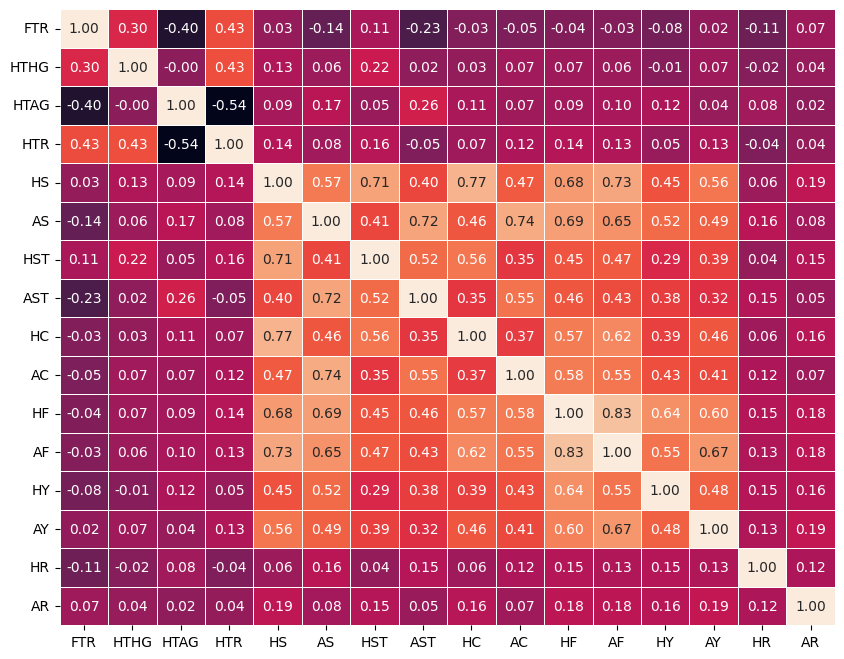

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation = df.corr(numeric_only=True)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(correlation, annot=True, linewidths=.5, fmt='.2f', cbar=False, ax=ax)
plt.show()

In [33]:
df.shape

(8746, 19)

In [8]:
# create dummy variables for the HomeTeam and AwayTeam columns
dummies_home = pd.get_dummies(df['HomeTeam'], prefix='home')
dummies_away = pd.get_dummies(df['AwayTeam'], prefix='away')
df_all = pd.concat([df, dummies_home, dummies_away], axis=1)
df_all = df_all.drop(['HomeTeam', 'AwayTeam'], axis=1)

In [40]:
# safe the whole dataframe in the 
df_all.to_csv('..\\data\\processed\\All_93-22.csv', index=False)

In [41]:
for team in df['HomeTeam'].unique():
    team_info = df[df['HomeTeam'] == team].reset_index(drop = True)

    # create dummy variables for the HomeTeam and AwayTeam columns
    dummies_home = pd.get_dummies(team_info['HomeTeam'], prefix='home')
    dummies_away = pd.get_dummies(team_info['AwayTeam'], prefix='away')
    team_info = pd.concat([team_info, dummies_home, dummies_away], axis=1)
    team_info = team_info.drop(['HomeTeam', 'AwayTeam'], axis=1)

    # write team info to specific file
    team_file = '..\\data\\processed\\{}_93-22.csv'.format(team)
    team_info.to_csv(team_file, index=False)